In [69]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()
sns.set_style('whitegrid')
sns.set_color_codes()

In [2]:
%%time
item_categories_df = pd.read_csv("../data/item_categories.csv")
items_df = pd.read_csv("../data/items.csv") 
train_df = pd.read_csv("../data/sales_train.csv")
sample_submission = pd.read_csv("../data/sample_submission.csv")
shops_df = pd.read_csv("../data/shops.csv")
test_df = pd.read_csv("../data/test.csv")

CPU times: user 1.74 s, sys: 253 ms, total: 1.99 s
Wall time: 2.01 s


## 데이터 탐색
- EDA 전에 데이터의 모양을 파악해보기

In [5]:
item_categories_df.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [6]:
items_df.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [7]:
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [8]:
sample_submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [9]:
shops_df.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [10]:
test_df.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


- 우선 아이템 카테고리, 아이템 id를 연결
- shop과 item은 러시아어로 작성되어 있음 (대회 제공이 러시아 회사니까)

In [11]:
item_categories_df.describe()

,item_category_id
count,84.000000
mean,41.500000
std,24.392622
min,0.000000
25%,20.750000
50%,41.500000
75%,62.250000
max,83.000000


In [13]:
items_df.describe()

,item_id,item_category_id
count,22170.00000,22170.000000
mean,11084.50000,46.290753
std,6400.07207,15.941486
min,0.00000,0.000000
25%,5542.25000,37.000000
50%,11084.50000,40.000000
75%,16626.75000,58.000000
max,22169.00000,83.000000


In [22]:
pd.set_option('float_format', '{:.3f}'.format)
train_df.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935849.000,2935849.000,2935849.000,2935849.000,2935849.000
mean,14.570,33.002,10197.227,890.853,1.243
std,9.423,16.227,6324.297,1729.800,2.619
min,0.000,0.000,0.000,-1.000,-22.000
25%,7.000,22.000,4476.000,249.000,1.000
50%,14.000,31.000,9343.000,399.000,1.000
75%,23.000,47.000,15684.000,999.000,1.000
max,33.000,59.000,22169.000,307980.000,2169.000


In [15]:
shops_df.describe()

,shop_id
count,60.000000
mean,29.500000
std,17.464249
min,0.000000
25%,14.750000
50%,29.500000
75%,44.250000
max,59.000000


In [3]:
train_full = pd.merge(train_df, items_df, how='left', on=['item_id','item_id'])
train_full = pd.merge(train_full, item_categories_df, how='left', on=['item_category_id','item_category_id'])
train_full = pd.merge(train_full, shops_df, how='left', on=['shop_id','shop_id'])

In [4]:
train_full['date'] = pd.to_datetime(train_full['date'], format='%d.%m.%Y')
train_full['month'] = train_full['date'].dt.month
train_full['year'] = train_full['date'].dt.year

In [26]:
train_full.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,month,year
2935844,2015-10-10,33,25,7409,299.000,1.000,V/A Nu Jazz Selection (digipack),55,Музыка - CD локального производства,"Москва ТРК ""Атриум""",10,2015
2935845,2015-10-09,33,25,7460,299.000,1.000,V/A The Golden Jazz Collection 1 2CD,55,Музыка - CD локального производства,"Москва ТРК ""Атриум""",10,2015
2935846,2015-10-14,33,25,7459,349.000,1.000,V/A The Best Of The 3 Tenors,55,Музыка - CD локального производства,"Москва ТРК ""Атриум""",10,2015
2935847,2015-10-22,33,25,7440,299.000,1.000,V/A Relax Collection Planet MP3 (mp3-CD) (jewel),57,Музыка - MP3,"Москва ТРК ""Атриум""",10,2015
2935848,2015-10-03,33,25,7460,299.000,1.000,V/A The Golden Jazz Collection 1 2CD,55,Музыка - CD локального производства,"Москва ТРК ""Атриум""",10,2015


In [5]:
col = ['date_block_num', 'date', 'month', 'year', 'shop_id', 'item_category_id', 'item_id', 'item_price',
       'item_cnt_day', 'shop_name', 'item_category_name','item_name',]
train_full = train_full[col]
train_full['revenue'] = train_full.item_price * train_full.item_cnt_day

In [6]:
train_full.tail()

,date_block_num,date,month,year,shop_id,item_category_id,item_id,item_price,item_cnt_day,shop_name,item_category_name,item_name,revenue
2935844,33,2015-10-10,10,2015,25,55,7409,299.0,1.0,"Москва ТРК ""Атриум""",Музыка - CD локального производства,V/A Nu Jazz Selection (digipack),299.0
2935845,33,2015-10-09,10,2015,25,55,7460,299.0,1.0,"Москва ТРК ""Атриум""",Музыка - CD локального производства,V/A The Golden Jazz Collection 1 2CD,299.0
2935846,33,2015-10-14,10,2015,25,55,7459,349.0,1.0,"Москва ТРК ""Атриум""",Музыка - CD локального производства,V/A The Best Of The 3 Tenors,349.0
2935847,33,2015-10-22,10,2015,25,57,7440,299.0,1.0,"Москва ТРК ""Атриум""",Музыка - MP3,V/A Relax Collection Planet MP3 (mp3-CD) (jewel),299.0
2935848,33,2015-10-03,10,2015,25,55,7460,299.0,1.0,"Москва ТРК ""Атриум""",Музыка - CD локального производства,V/A The Golden Jazz Collection 1 2CD,299.0


In [29]:
print("Description of training set")
print("Shape: \t\t\t", train_full.shape)
print("#NaNs: \t\t\t", train_full.isna().sum().sum()) # No NaN
print("#Shops: \t\t", train_full.shop_id.nunique())
print("#Item Categories: \t", train_full.item_category_id.nunique())
print("#Items: \t\t", train_full.item_id.nunique())
print("#Months: \t\t", train_full.date_block_num.nunique())
print("Date range from: \t", train_full.date.min(), " to ", train_full.date.max())
print("Price range from: \t", train_full.item_price.min(), " to ", train_full.item_price.max())
print("Units Sold range from: \t", train_full.item_cnt_day.min(), " to ", train_full.item_cnt_day.max())
print("Revenue range from: \t", train_full.revenue.min(), " to ", train_full.revenue.max())

train_full.head(3)

Description of training set
Shape: 			 (2935849, 13)
#NaNs: 			 0
#Shops: 		 60
#Item Categories: 	 84
#Items: 		 21807
#Months: 		 34
Date range from: 	 2013-01-01 00:00:00  to  2015-10-31 00:00:00
Price range from: 	 -1.0  to  307980.0
Units Sold range from: 	 -22.0  to  2169.0
Revenue range from: 	 -68970.0  to  1829990.0000013


,date_block_num,date,month,year,shop_id,item_category_id,item_id,item_price,item_cnt_day,shop_name,item_category_name,item_name,revenue
0,0,2013-01-02,1,2013,59,37,22154,999.000,1.000,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,ЯВЛЕНИЕ 2012 (BD),999.000
1,0,2013-01-03,1,2013,25,58,2552,899.000,1.000,"Москва ТРК ""Атриум""",Музыка - Винил,DEEP PURPLE The House Of Blue Light LP,899.000
2,0,2013-01-05,1,2013,25,58,2552,899.000,-1.000,"Москва ТРК ""Атриум""",Музыка - Винил,DEEP PURPLE The House Of Blue Light LP,-899.000


- Price, Units Sold, Revenue가 마이너스인 것들은 뭘까?

In [49]:
train_full['month'].value_counts().sort_index()

1     303561
2     270251
3     284057
4     228289
5     224836
6     237428
7     234857
8     248415
9     219882
10    227077
11    183164
12    274032
Name: month, dtype: int64

In [50]:
train_full['year'].value_counts().sort_index()

2013    1267562
2014    1055861
2015     612426
Name: year, dtype: int64

In [51]:
train_full['shop_id'].value_counts().sort_index()

0       9857
1       5678
2      25991
3      25532
4      38242
5      38179
6      82663
7      58076
8       3412
9       3751
10     21397
11       499
12     34694
13     17824
14     36979
15     59511
16     52734
17     22950
18     53227
19     63911
20      1792
21     58133
22     45434
23      6963
24     53032
25    186104
26     53910
27    105366
28    142234
29     49225
30     50860
31    235636
32      7947
33      5027
34      5752
35     58445
36       306
37     39638
38     46013
39     13440
40      4257
41     41967
42    109253
43     39282
44     39530
45     35891
46     66321
47     56695
48     21612
49     15849
50     65173
51     44433
52     43502
53     52921
54    143480
55     34769
56     69573
57    117428
58     71441
59     42108
Name: shop_id, dtype: int64

In [52]:
train_full['date_block_num'].value_counts().sort_index()

0     115690
1     108613
2     121347
3      94109
4      91759
5     100403
6     100548
7     104772
8      96137
9      94202
10     96736
11    143246
12     99349
13     89830
14     92733
15     77906
16     78529
17     82408
18     78760
19     86614
20     73157
21     79361
22     86428
23    130786
24     88522
25     71808
26     69977
27     56274
28     54548
29     54617
30     55549
31     57029
32     50588
33     53514
Name: date_block_num, dtype: int64

In [54]:
train_full['item_category_name'].value_counts()

Кино - DVD                                  564652
Игры PC - Стандартные издания               351591
Музыка - CD локального производства         339585
Игры - PS3                                  208219
Кино - Blu-Ray                              192674
Игры - XBOX 360                             146789
Игры PC - Дополнительные издания            121539
Игры - PS4                                   79058
Подарки - Мягкие игрушки                     53845
Подарки - Настольные игры (компактные)       53227
Подарки - Фигурки                            47177
Кино - Blu-Ray 3D                            42718
Программы - Для дома и офиса                 42603
Подарки - Развитие                           41706
Подарки - Настольные игры                    37635
Подарки - Сувениры (в навеску)               35484
Кино - Коллекционное                         32748
Музыка - MP3                                 32490
Игры - PSP                                   32164
Подарки - Сумки, Альбомы, Коври

- 시각화 아이디어
    - 월별 판매 total
    - 월별 판매 unique
    - 주별 판매 total
    - 주별 판매 unique
    - 시간의 흐름에 따른
        - 아이템별 판매 total
        - 아이템별 판매 unique
        - shop별 판매 total
        - shop별 판매 unique
    - 카테고리별 판매 개수
        - 특정 카테고리가 날짜에 반응하는가?
    - 러시아에 블랙프라이데이 같은 날이 있는가?
    - 러시아 공휴일에 따라 다른가?
    - 평일/주말에 따라 다른가?

In [8]:
train_full

,date_block_num,date,month,year,shop_id,item_category_id,item_id,item_price,item_cnt_day,shop_name,item_category_name,item_name,revenue
0,0,2013-01-02,1,2013,59,37,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,ЯВЛЕНИЕ 2012 (BD),999.00
1,0,2013-01-03,1,2013,25,58,2552,899.00,1.0,"Москва ТРК ""Атриум""",Музыка - Винил,DEEP PURPLE The House Of Blue Light LP,899.00
2,0,2013-01-05,1,2013,25,58,2552,899.00,-1.0,"Москва ТРК ""Атриум""",Музыка - Винил,DEEP PURPLE The House Of Blue Light LP,-899.00
3,0,2013-01-06,1,2013,25,58,2554,1709.05,1.0,"Москва ТРК ""Атриум""",Музыка - Винил,DEEP PURPLE Who Do You Think We Are LP,1709.05
4,0,2013-01-15,1,2013,25,56,2555,1099.00,1.0,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),1099.00
5,0,2013-01-10,1,2013,25,59,2564,349.00,1.0,"Москва ТРК ""Атриум""",Музыка - Музыкальное видео,DEEP PURPLE Perihelion: Live In Concert DVD (К...,349.00
6,0,2013-01-02,1,2013,25,56,2565,549.00,1.0,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства,DEEP PURPLE Stormbringer (фирм.),549.00
7,0,2013-01-04,1,2013,25,55,2572,239.00,1.0,"Москва ТРК ""Атриум""",Музыка - CD локального производства,DEFTONES Koi No Yokan,239.00
8,0,2013-01-11,1,2013,25,55,2572,299.00,1.0,"Москва ТРК ""Атриум""",Музыка - CD локального производства,DEFTONES Koi No Yokan,299.00
9,0,2013-01-03,1,2013,25,55,2573,299.00,3.0,"Москва ТРК ""Атриум""",Музыка - CD локального производства,DEL REY LANA Born To Die,897.00


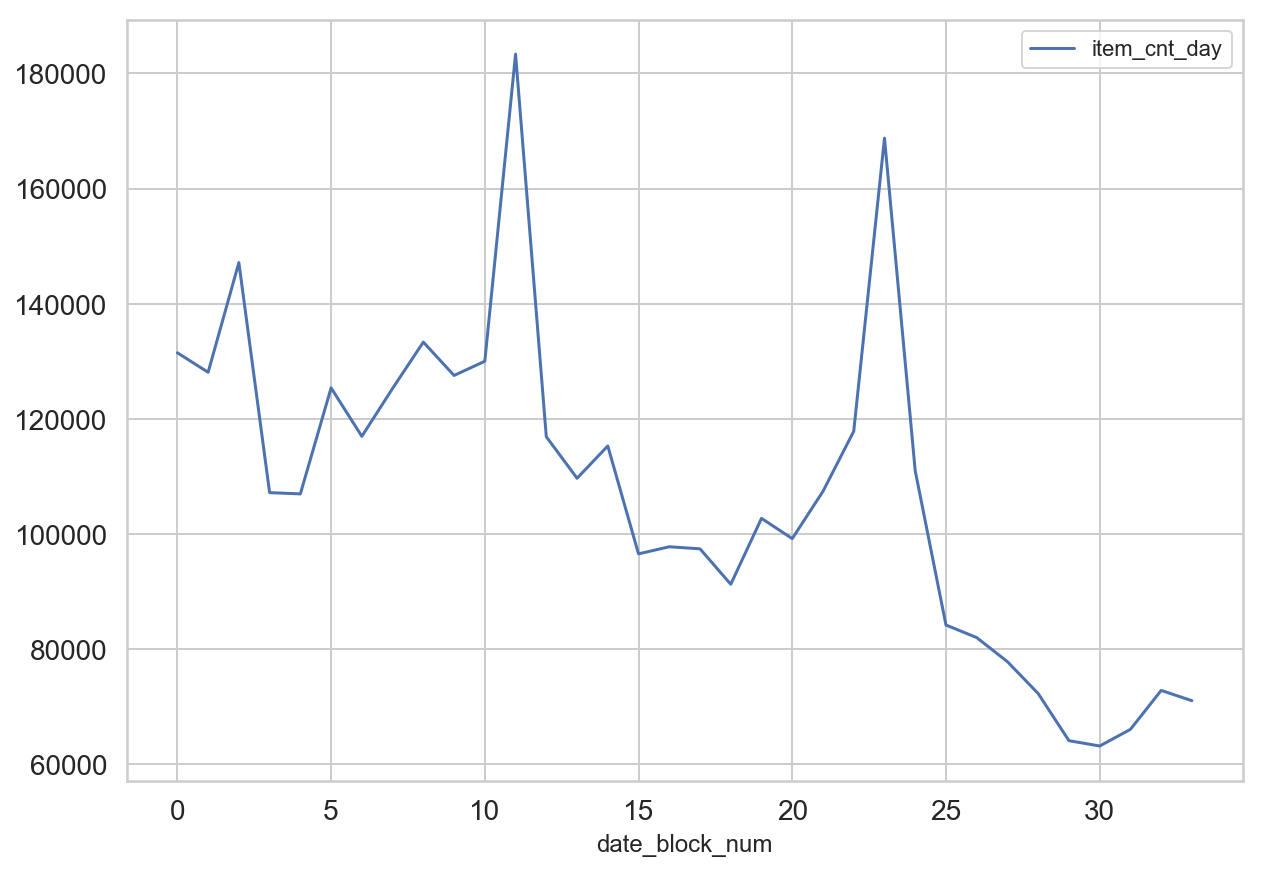

In [66]:
grouped = train_full.groupby('date_block_num')[['item_cnt_day']].agg(sum)
grouped.plot(figsize=(10,7), fontsize=14);

## Shop별 판매

CPU times: user 14 s, sys: 1.9 s, total: 15.9 s
Wall time: 6.16 s


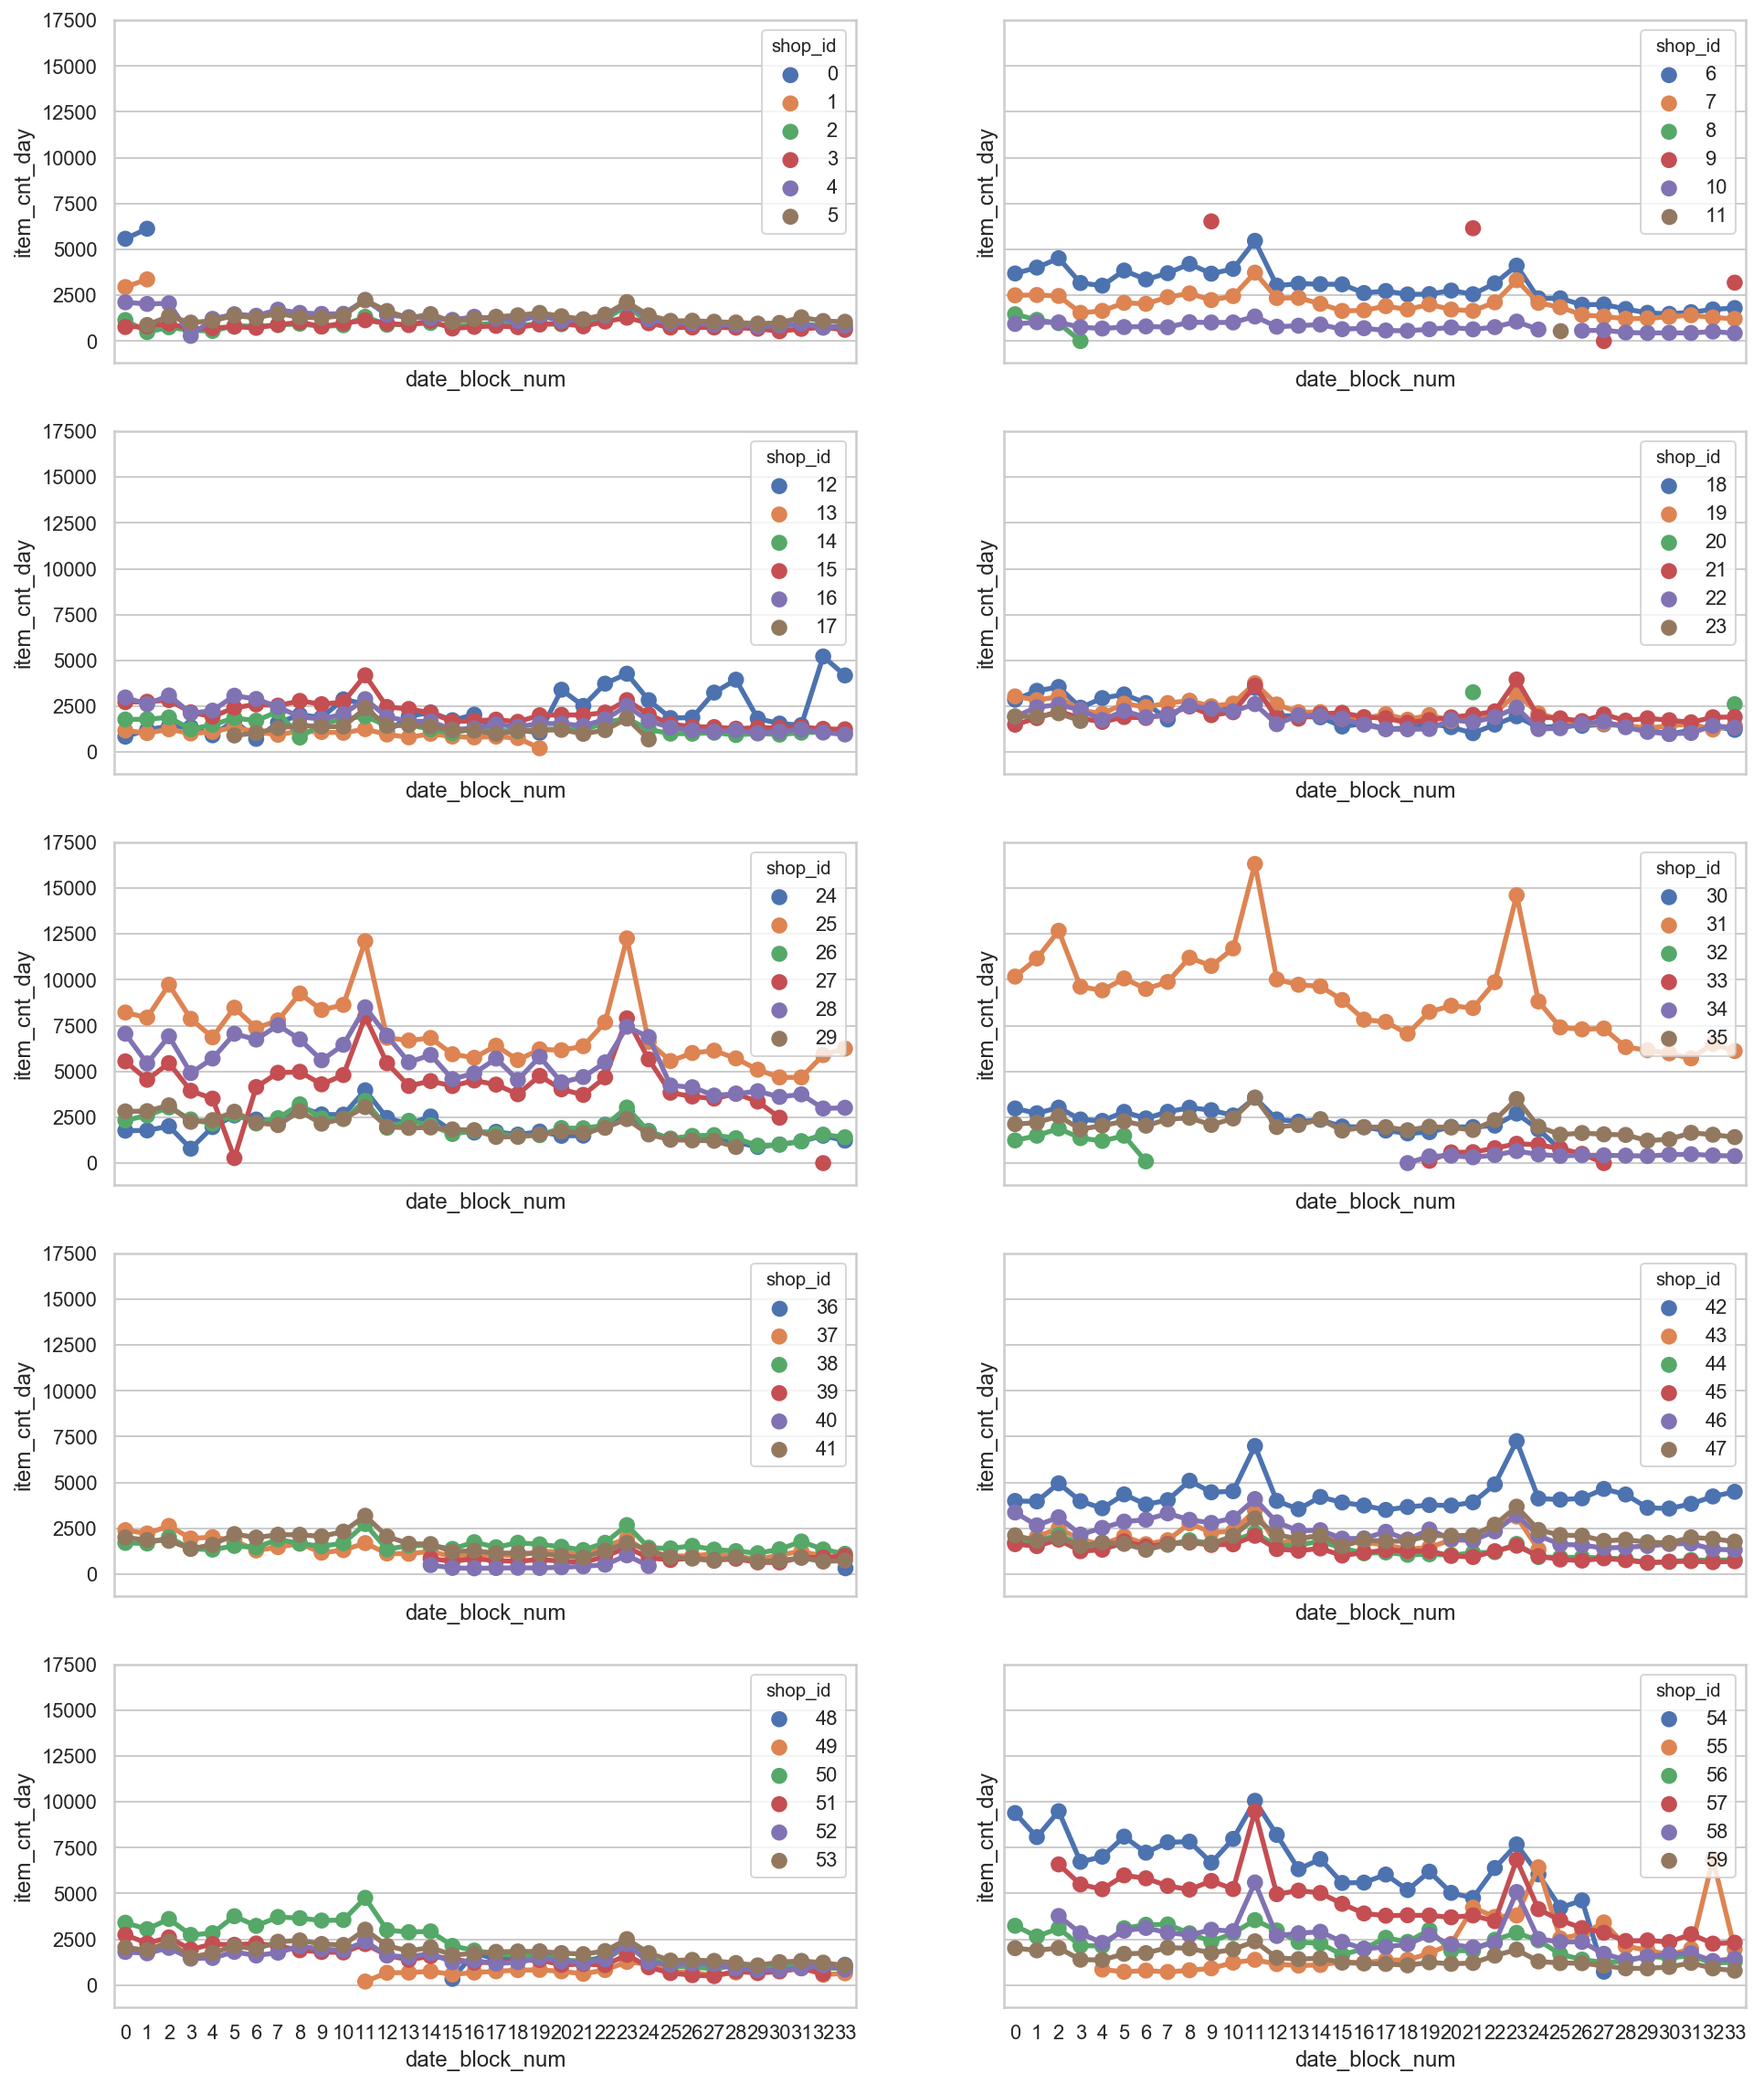

In [71]:
%%time
grouped = pd.DataFrame(train_full.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(grouped.shop_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='shop_id', data=grouped[np.logical_and(count*id_per_graph <= grouped['shop_id'], grouped['shop_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1

- 주기가 있어 보이기 때문에 shop_id로 mean encoding이 효과가 있을 것으로 예상됨

## 아이템 카테고리별

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


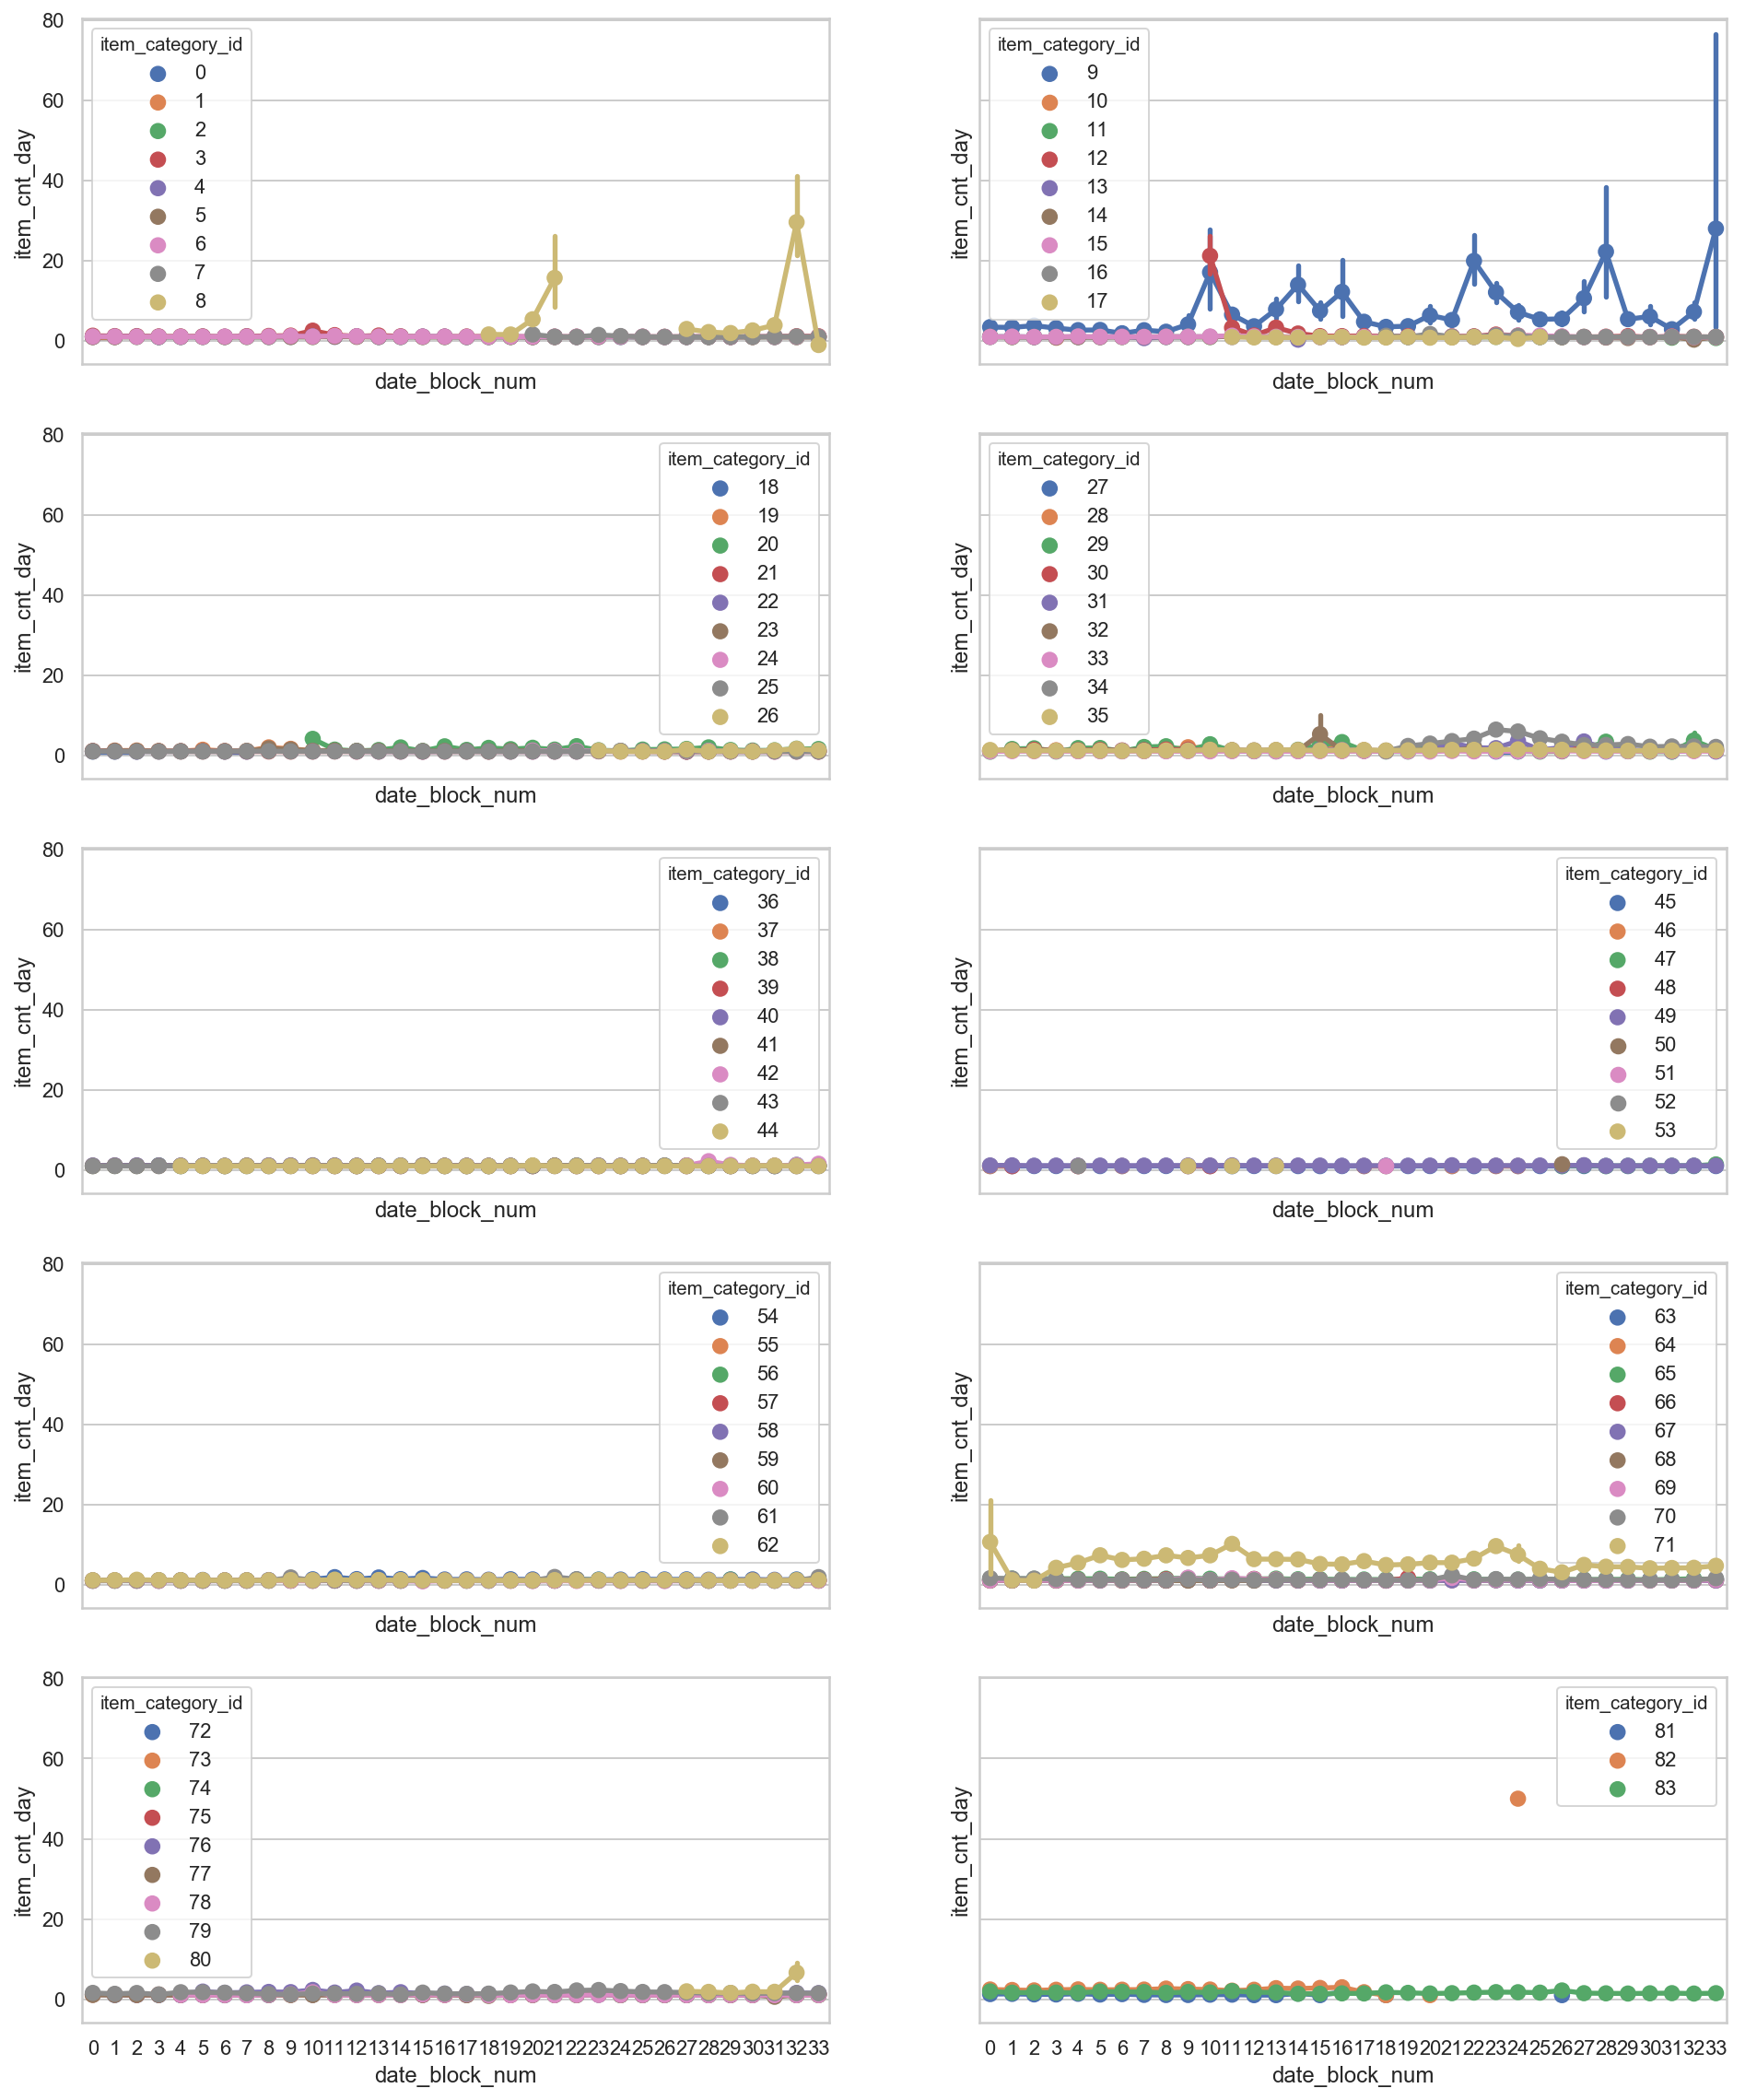

In [81]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(train_full.item_category_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='item_category_id', 
                      data=train_full[np.logical_and(count*id_per_graph <= train_full['item_category_id'], 
                                                     train_full['item_category_id'] < (count+1)*id_per_graph)], 
                      ax=axes[i][j])
        count += 1


- 주기가 있는 제품이 있기 때문에 카테고리 id로 mean encoding이 효과적일 것으로 예상